# Week 4 - Word Embeddings Supplemental

This notebook contains two additional word embedding possibilities.

For this notebook we will be using the following packages

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import nltk #For stop words and stemmers
import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA
import copy

#gensim uses a couple of deprecated features
#we can't do anything about them so lets ignore them 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

c:\users\andrew\appdata\local\programs\python\python36\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Data

This notebook relies on a few data files that are not in the git repo due to their size please download and unzip [this](https://github.com/Computational-Content-Analysis-2018/Upcoming/raw/master/data/supplement.zip) (472MB) file in the data directory.

# The Score Function

The score function is a simple calculation developed by [Matt Taddy](https://arxiv.org/pdf/1504.07295.pdf) to calculate the likelihood that a given text would have been generated by a word-embedding model by summing the inner product between each pair of the text's word vectors. 

Here, we explore this using a model trained with millions of resumes from the CareerBuilder website (we can't share the private resumes...but we can share a model built with them :-):

In [2]:
resume_model  = gensim.models.word2vec.Word2Vec.load('../data/resumeAll.model')

We can examine the vacabularies of this model by building a word-index map:

In [3]:
vocab = resume_model.index2word

Let's just load the sample and take a look at it. The sentences in each job description are already tokenized and normalized.

In [4]:
sampleDF = pandas.read_csv('../data/SampleJobAds.csv', index_col = False)
#We need to convert the last couple columns from strings to lists
sampleDF['tokenized_sents'] = sampleDF['tokenized_sents'].apply(lambda x: eval(x))
sampleDF['normalized_sents'] = sampleDF['normalized_sents'].apply(lambda x: eval(x))
sampleDF

,Unnamed: 0,hiringOrganization_organizationName,jobDescription,jobLocation_address_region,jobLocation_geo_latitude,jobLocation_geo_longitude,qualifications,responsibilities,tokenized_sents,normalized_sents
0,158844,"Golfsmith International, Inc.","""Sales Associate Tracking Code 220425-971 Job ...",California,33.91918,-118.41647,NaN,"""Ensure each Customer receives exceptional ser...","[[``, Sales, Associate, Tracking, Code, 220425...","[[sales, associate, tracking, code, job, descr..."
1,257645,Intel,For PHY system engineering team within the Wir...,NaN,NaN,NaN,NaN,NaN,"[[For, PHY, system, engineering, team, within,...","[[for, phy, system, engineering, team, within,..."
2,107875,Florida Hospital,*RN Medical Oncology PCU Orlando - Nights* Flo...,Florida,28.53834,-81.37924,NaN,NaN,"[[*RN, Medical, Oncology, PCU, Orlando, -, Nig...","[[medical, oncology, pcu, orlando, florida, ho..."
3,202394,Hitachi Data Systems,Title: Specialist Sales Account Representative...,NaN,NaN,NaN,NaN,NaN,"[[Title, :, Specialist, Sales, Account, Repres...","[[title, specialist, sales, account, represent..."
4,109675,Footprint Retail Services,**Footprint Retail Services** **Job Descriptio...,NaN,NaN,NaN,NaN,A Merchandiser must complete all assigned merc...,"[[**Footprint, Retail, Services**, **Job, Desc...","[[retail, job, title, retail, merchandiser, re..."
5,215973,Home Depot,Position Purpose: Provide outstanding service ...,Indiana,41.13060,-85.12886,NaN,Provide outstanding service to ensure efficien...,"[[Position, Purpose, :, Provide, outstanding, ...","[[position, purpose, provide, outstanding, ser..."
6,207524,Home Depot,The Asset Protection Specialist is primarily r...,New Jersey,40.21455,-74.61932,Must be eighteen years of age or older. Must p...,NaN,"[[The, Asset, Protection, Specialist, is, prim...","[[the, asset, protection, specialist, is, prim..."
7,64426,East West Bank,# Job Description East West Bank is one of the...,California,34.06862,-118.02757,NaN,We are currently seeking a Customer Service Ce...,"[[#, Job, Description, East, West, Bank, is, o...","[[job, description, east, west, bank, is, one,..."
8,245192,IBM,Job Description IBM is seeking to hire a Senio...,NaN,NaN,NaN,NaN,NaN,"[[Job, Description, IBM, is, seeking, to, hire...","[[job, description, ibm, is, seeking, to, hire..."
9,202429,Hitachi Data Systems,Title: Field Solutions Engineer Location: New ...,NaN,NaN,NaN,NaN,Job Functions;Specific duties in this role wil...,"[[Title, :, Field, Solutions, Engineer, Locati...","[[title, field, solutions, engineer, location,..."


Let's define a function to calculate the likelihood of each job description. The idea is borrowed from [Matt Taddy](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/deepir.ipynb), who shows how a document can be characterized as the inner product of the distance between its words. In other words, this analysis will show which job ads are most likely to find an appropriate pool of workers in the resume bank that generated our word embedding.  

In [5]:
def adprob(ad, model):
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

Let's apply this function to every job description.

In [6]:
sampleDF['likelihood'] = sampleDF['normalized_sents'].apply(lambda x: adprob(x, resume_model))

Let's take a look at the top 5 job descriptions that have the highest likelihood.

In [7]:
for ad in sampleDF.sort_values(by = 'likelihood', ascending = False)['jobDescription'][:5]:
    print (ad + '\n\n')

Project Engineering including below jobs: 1. Hardware designing of DCS 2. Software configurations, programming, testing of DCS/PLC 3. Testing and FAT 4. Installation and commissioning. 5. Material ordering, approvals of datasheets. 6. HSE compliance as per HSE directives of HON. BE / B. Tech - Instrumentation / Control / Electronics. **Job:** **Engineering* **Title:** *Systems Engineer* **Location:** *IND-MH-Pune* **Requisition ID:** *00302235*


Like talking on the phone? Enjoy giving great customer service? Use those skills while working flexible,part time hours.


*# Positions:* 2 *Location:* US - UT - Orem *Category:* Engineering


Title: Respiratory Therapy, Intern Location: XX-XX-XX


Title: Position Opening at Illinois Wesleyan University Location: US-IL-Bloomington




Let's take a look at the bottom 5 job descriptions that have the lowest likelihood to be matched by the resumes.

In [8]:
for ad in sampleDF.sort_values(by = 'likelihood')['jobDescription'][:5]:
    print (ad + '\n\n')

Title: Contract Svc Admin Location: United States\-Michigan\-Caledonia Other Locations: JOB SUMMARY: ESSENTIAL DUTIES AND RESPONSIBILITIES: _ Other duties may be assigned:_ Prepare GPO rebate data for upload into STARR system oEnsure accurate data loads oProcess data into required reports oEnsure that GPOs are paid accurately and timely Prepare Sales Tracing data for upload into STARR system oEnsure accurate data loads oProcess data into required reports Prepare Rebate data for upload into STARR system oEnsure accurate data loads oProcess data into required reports oEnsure that distributors are accurately taking rebates against open invoices Manage work flow throughout the sales contracting process Ensure compliance with contract policies and performance requirements Assist in the preparation of charts and sales reports and analytics for customers and Management oQuarterly Reports oSales Tracing Answers customers and internal sale/customer service staff questions regarding pricing Mana

We can do the same for phrases corresponding to job skills.

In [9]:
adprob([["python", "programming"]], resume_model)

-14.355247

In [10]:
adprob([["basic", "programming"]], resume_model)

-8.93109

Basic programming appears to be more likely in this pool of resumes than python programming. 

We can also do some simple statistics. Unfortunately, we don't have a large sample here. Nevertheless, let's first look at the mean likelihood score of each hiring organization. Some organizations will do well to hire on CareerBuilder...while others will not.

In [11]:
sampleDF.groupby("hiringOrganization_organizationName")[['likelihood']].mean().sort_values('likelihood', ascending = False)

,likelihood
hiringOrganization_organizationName,
Honeywell,-25.974749
Legrand North America,-40.500500
Franciscan St. Eilzabeth Health,-43.167206
Illinois Wesleyan University,-52.681591
Gold's Gym,-75.230896
Jewel-Osco,-80.965462
Ingersoll Rand,-81.494949
Kaiser Permanente,-85.523113
Hallmark Health,-86.037094


We can also look at the mean likelihood of each state.

In [12]:
sampleDF.groupby("jobLocation_address_region")[['likelihood']].mean().sort_values('likelihood', ascending = False)

,likelihood
jobLocation_address_region,
Utah,-40.500500
Montana,-63.730721
Connecticut,-67.623466
Kansas,-85.259682
Tennessee,-93.188822
Illinois,-93.989101
New Hampshire,-94.109772
Georgia,-102.271820
South Carolina,-103.527328


You would increase the sample size if you want to do a more serious study.

## <span style="color:red">*Exercise 3a*</span>

<span style="color:red">**Do only 3a or 3b.** Construct cells immediately below this that calculate the scores for a small sample of documents from outside your corpus to identify which are *closest* to your corpus. Then calculate the scores for a few phrases or sentences to identify the ones most likely to have appeared in your corpus. Interrogate patterns associated with these document/phrase scores (e.g., which companies produced job ads most or least likely to find jobseekers in the resume corpus?) What do these patterns suggest about the boundaries of your corpus?

In [13]:
#my original corpus
letters = pandas.read_pickle('C:\\Users\\Andrew\\content-analysis-2018\\content-analysis-2018\\2-Corpus-Linguistics\\pandasDF.pkl')
letters.head()

,company,text,year
0,3M Letter,dear shareholder:\n\nthanks to the hard work o...,2000
1,Alcoa Letter,luluâ\nmumÂ» nl am.â\n\n \n\n \n\n1â0 ai...,2000
2,American Express Letter,"cardmembers, a reflection of our successful ef...",2000
3,AT&T Letter,the transformation of at&t\n\nthree years ago ...,2000
4,Boeing Letter,here is our plan for growing the boeing compan...,2000


In [14]:
#small sample of documents (berkshire hathaway annual letters to the shareholder from 2012-2016)
berkshire = pandas.read_pickle('C:\\Users\\Andrew\\content-analysis-2018\\content-analysis-2018\\4-Word-Embedding\\berkshire.pkl')
berkshire.head()

,company,text,year
0,Berkshire Hathaway,\nTo the Shareholders of Berkshire Hathaway In...,2012
1,Berkshire Hathaway,To the Shareholders of Berkshire Hathaway Inc....,2013
2,Berkshire Hathaway,To the Shareholders of Berkshire Hathaway Inc....,2014
3,Berkshire Hathaway,To the Shareholders of Berkshire Hathaway Inc....,2015
4,Berkshire Hathaway,BERKSHIRE HATHAWAY INC.\nTo the Shareholders o...,2016


In [15]:
#remove stop words while preserving sentence structure
letters['tokenized_sents'] = letters['text'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
letters['normalized_sents'] = letters['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

letters[:5]
#remove stop words while preserving sentence structure
berkshire['tokenized_sents'] = berkshire['text'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
berkshire['normalized_sents'] = berkshire['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

berkshire[:5]

,company,text,year,tokenized_sents,normalized_sents
0,Berkshire Hathaway,\nTo the Shareholders of Berkshire Hathaway In...,2012,"[[To, the, Shareholders, of, Berkshire, Hathaw...","[[shareholders, berkshire, hathaway, berkshire..."
1,Berkshire Hathaway,To the Shareholders of Berkshire Hathaway Inc....,2013,"[[To, the, Shareholders, of, Berkshire, Hathaw...","[[shareholders, berkshire, hathaway, berkshire..."
2,Berkshire Hathaway,To the Shareholders of Berkshire Hathaway Inc....,2014,"[[To, the, Shareholders, of, Berkshire, Hathaw...","[[shareholders, berkshire, hathaway, berkshire..."
3,Berkshire Hathaway,To the Shareholders of Berkshire Hathaway Inc....,2015,"[[To, the, Shareholders, of, Berkshire, Hathaw...","[[shareholders, berkshire, hathaway, berkshire..."
4,Berkshire Hathaway,BERKSHIRE HATHAWAY INC.\nTo the Shareholders o...,2016,"[[BERKSHIRE, HATHAWAY, INC., To, the, Sharehol...","[[berkshire, hathaway, shareholders, berkshire..."


In [16]:
#model my corpus
lettersW2V = gensim.models.word2vec.Word2Vec(letters['normalized_sents'].sum(), hs = 1, negative = 0)

In [17]:
berkshire['likelihood'] = berkshire['normalized_sents'].apply(lambda x: adprob(x, lettersW2V))


this code sorts the annual letters to the shareholder of berkshire hathaway from 2012-2016 in descending order of most likely to be included in the original corpus
NOTE: The 2014 letter is most likely to be in the corpus

In [18]:
for letter in berkshire.sort_values(by = 'likelihood', ascending = False)['text'][:5]:
    print (letter[:1000] + '\n\n')

To the Shareholders of Berkshire Hathaway Inc.:
Berkshire’s gain in net worth during 2014 was $18.3 billion, which increased the per-share book value of
both our Class A and Class B stock by 8.3%. Over the last 50 years (that is, since present management took over),
per-share book value has grown from $19 to $146,186, a rate of 19.4% compounded annually.*
During our tenure, we have consistently compared the yearly performance of the S&P 500 to the change in
Berkshire’s per-share book value. We’ve done that because book value has been a crude, but useful, tracking device
for the number that really counts: intrinsic business value.
In our early decades, the relationship between book value and intrinsic value was much closer than it is
now. That was true because Berkshire’s assets were then largely securities whose values were continuously restated
to reflect their current market prices. In Wall Street parlance, most of the assets involved in the calculation of book
value were “marked to 

Now looking at interesting phrases:              
Unsurpisingly 'earnings per share' is very likely to appear in my corpus.             
More interesting, 'climate change' seems more likely to appear in my corpus than 'employee training'

In [19]:
adprob([["climate", "change"]], lettersW2V)

-12.832985

In [20]:
adprob([["employee", "training"]], lettersW2V)

-16.850128

In [21]:
adprob([["earnings", "per","share"]], lettersW2V)

-3.5430477

I chose the Berkshire Hathaway letters because I was interested in relating an incredibly successful company, to my corpus of Dow Jones Letters. The fact that the 2014 letter is most likely to be in my corpus is interesting because it may simply reflect how my dataset has a large number of 2014 letters. This would indicate that letters are more similar to those within years than within companies. I will need to do the following Linguistic Change section to ascertain this possibility.

# Linguistic Change

Below is code that aligns the dimensions of multiple embeddings arrayed over time or some other dimension and allow identification of semantic chanage as the word vectors change their loadings for focal words. This code comes from the approach piloted at Stanford by William Hamilton, Daniel Jurafsky and Jure Lescovec [here](https://arxiv.org/pdf/1605.09096.pdf). 

In [22]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

In order to explore this, let's get some data that follows a time trend. We'll look at conference proceedings from the American Society for Clinical Oncologists.

In [23]:
ascoDF = pandas.read_csv("../data/ASCO_abstracts.csv", index_col=0)

In [24]:
ascoDF.head()

,Year,AbstractCategory,Title,FirstAuthor,Body,AbstractPublicationID
0,1995,Lung Cancer,Treatment of non-small cell lung cancer with c...,GP Stathopoulos,Cisplatin compound is established as the main ...,1181
1,1995,Breast Cancer,Treatment of primary breast cancer without mas...,A Bluming,"Between March 24, 1977, and March 24, 1983, 15...",270
2,1995,Gynecologic Cancer,Treatment of relapsed ovarian carcinoma with e...,M Metzner,ECF has established activity and a high respon...,784
3,1995,Lung Cancer,Treatment of small cell lung cancer (SCLC) wit...,JD Hainsworth,"In 7/93, we began investigation of a three-dru...",1197
4,1995,Other Gastrointestinal Cancer,Vaccine-based (active specific) chemoimmunothe...,SH Itzkowitz,Active specific immunotherapy (ASI) is the adm...,549


Prepare for wor2vec

In [25]:
ascoDF['tokenized_sents'] = ascoDF['Body'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
ascoDF['normalized_sents'] = ascoDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = lucem_illud.stop_words_basic) for s in x])

We will be creating many embeddings so we have created this function to do most of the work. It creates two collections of embeddings, one the original and one the aligned.

In [26]:
def compareModels(df, category, sort = True):
    """If you are using time as your category sorting is important"""
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF['normalized_sents'].sum())
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

Now we generate the models

In [27]:
rawEmbeddings, comparedEmbeddings = compareModels(ascoDF, 'Year')

We need to compare them across all permutions so we will define another function to help, we will be using 1 - cosine similarity as that gives a more intitive range of 0-2 with low values meaning little change and high meaning lots of change

In [28]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            v1 = embeddingsDict[cat][0][word]
            v2 = embed[word]
            cs = sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(v1, axis = 0),np.expand_dims(v2, axis =0))
            dists[cat].append(np.abs(1 - cs[0,0]))
    return pandas.DataFrame(dists, index = cats)

Lets look at a couple words

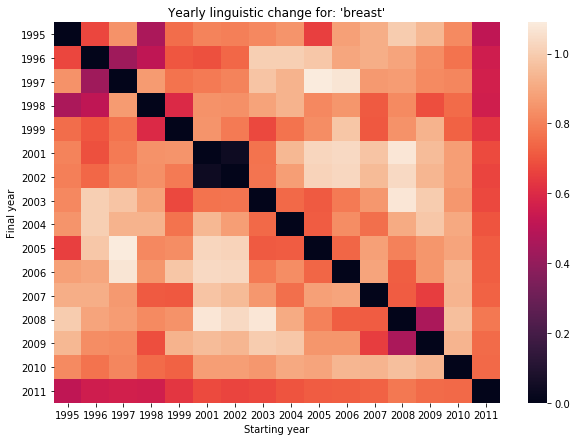

In [29]:
targetWord = 'breast'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

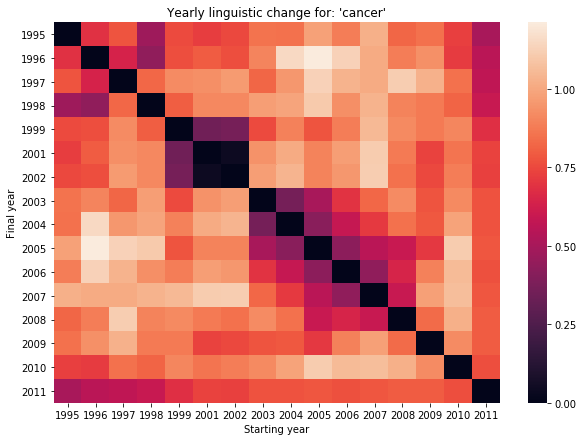

In [30]:
targetWord = 'cancer'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

We can also ask which words changed the most

In [31]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        v1 = embeddingsDict[cats[0]][0][word]
        v2 = embed[word]
        
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(v1, axis = 0),np.expand_dims(v2, axis =0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)
    

In [32]:
wordDivergences = findMostDivergent(comparedEmbeddings)

Found 1446 words to compare


The most divergent words are:

In [33]:
wordDivergences[:10]

[('iv', 13.96340346802026),
 ('b', 13.886146380536957),
 ('toler', 13.876941934227943),
 ('c', 13.855305475648493),
 ('arm', 13.520078282803297),
 ('n', 13.39088229695335),
 ('toxic', 13.3859519129619),
 ('cell', 13.335921808611602),
 ('mg', 13.319655414205045),
 ('stage', 13.245675072073936)]

And the least

In [34]:
wordDivergences[-10:]

[('call', 1.5094175934791565),
 ('aid', 1.4987395405769348),
 ('tri', 1.4181360006332397),
 ('widespread', 1.3182113766670227),
 ('uncertain', 1.2639775276184082),
 ('view', 1.2578518390655518),
 ('gave', 1.2474986910820007),
 ('alway', 1.2331923842430115),
 ('choos', 1.2206901907920837),
 ('situat', 0.8753830790519714)]

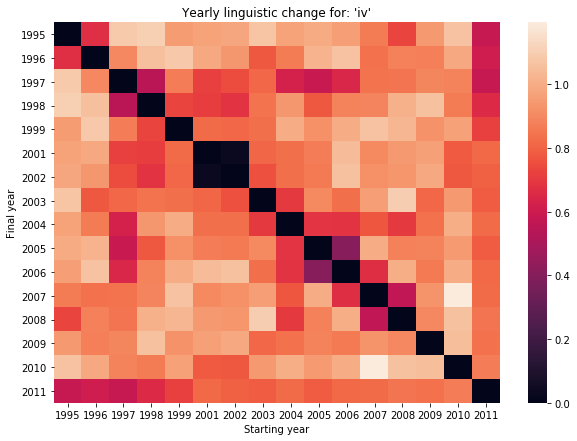

In [35]:
targetWord = wordDivergences[0][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

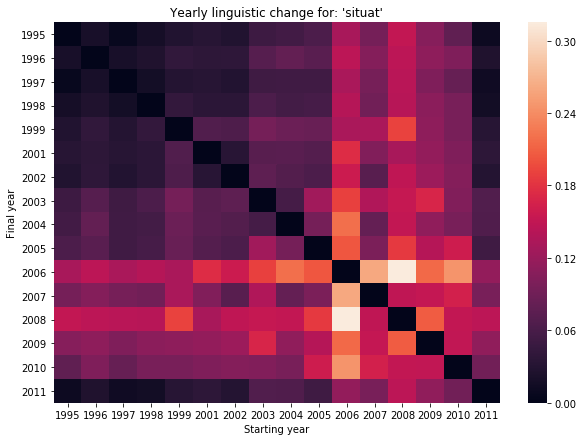

In [36]:
targetWord = wordDivergences[-1][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

## <span style="color:red">*Exercise 3b*</span>

<span style="color:red">**Do only 3a or 3b.** Construct cells immediately below this that align word embeddings over time or across domains/corpora. Interrogate the spaces that result and ask which words changed most and least over the entire period or between contexts/corpora. What does this reveal about the social game underlying your space? 

In [37]:
raw, comp = compareModels(letters,'year')

In [38]:
wordDivergences = findMostDivergent(comp)

Found 130 words to compare


In [39]:
#most divergent
wordDivergences[:10]

[('online', 4.600606083869934),
 ('communities', 3.821645274758339),
 ('level', 3.3456448167562485),
 ('approach', 3.3289745151996613),
 ('helping', 3.3235607147216797),
 ('mobile', 3.2694899269845337),
 ('report', 3.054334618151188),
 ('model', 2.7245147600769997),
 ('teams', 2.694915661588311),
 ('portfolio', 2.551423117518425)]

In [40]:
#least divergent
wordDivergences[-10:]

[('innovation', 0.7699464559555054),
 ('well', 0.764573335647583),
 ('p', 0.750619113445282),
 ('us', 0.7458460628986359),
 ('technology', 0.741057276725769),
 ('company', 0.7277430891990662),
 ('business', 0.7040969729423523),
 ('growth', 0.6104775667190552),
 ('products', 0.580548882484436),
 ('new', 0.5133163332939148)]

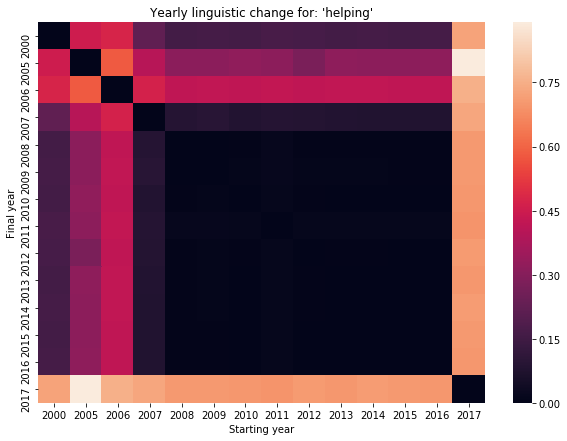

In [41]:
targetWord = 'helping'

pltDF = getDivergenceDF(targetWord, comp)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

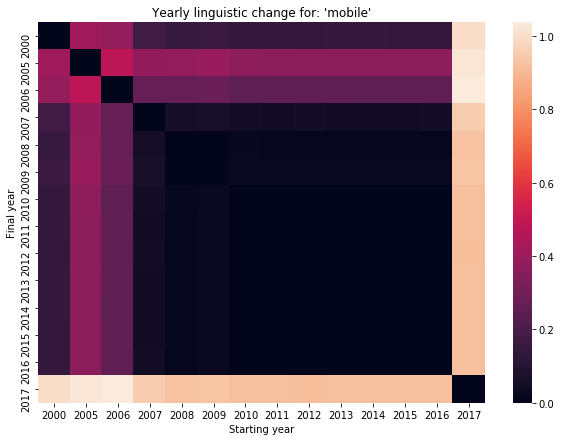

In [42]:
targetWord = 'mobile'

pltDF = getDivergenceDF(targetWord, comp)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

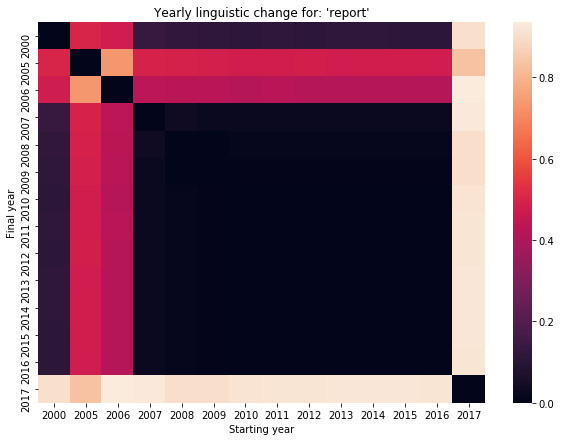

In [43]:
targetWord = 'report'

pltDF = getDivergenceDF(targetWord, comp)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

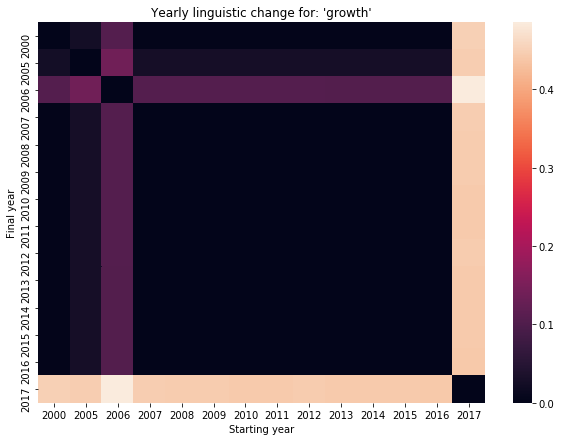

In [44]:
targetWord = 'growth'

pltDF = getDivergenceDF(targetWord, comp)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()


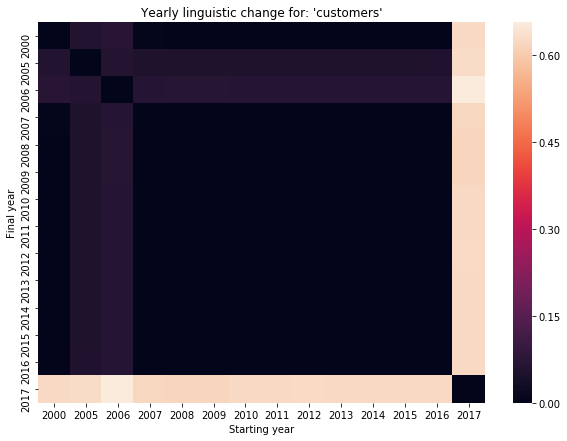

In [45]:
targetWord = 'customers'

pltDF = getDivergenceDF(targetWord, comp)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

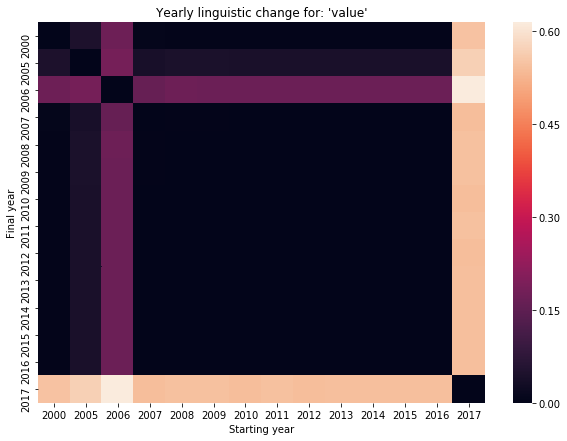

In [46]:
targetWord = 'value'

pltDF = getDivergenceDF(targetWord, comp)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

## experimentation with the across time comparison -- when using the comparisonModels function on companies instead of years, I receive error: 0-dimensional array given. Array must be at least two-dimensional
I am trying to remedy this

In [70]:
def compModels(df, category, sort = True):
    """If you are using time as your category sorting is important"""
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF['normalized_sents'].sum())
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            v1 = embeddings_aligned[catOuter][-1]
            v2 = embeddings_raw[catInner]
            try:
                embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(np.expand_dims(v1, axis = 0),np.expand_dims(v2, axis =0)))
            except:
                break
    return embeddings_raw, embeddings_aligned

In [71]:
raw, comp = compModels(letters,'company')

In [72]:
wordDivergence = findMostDivergent(comp)

Found 3334 words to compare


In [73]:
#most divergent
wordDivergence[:10]

[('anniversary', 0),
 ('train', 0),
 ('respected', 0),
 ('achievements', 0),
 ('recruiting', 0),
 ('education', 0),
 ('strengths', 0),
 ('trend', 0),
 ('country', 0),
 ('letter', 0)]

In [74]:
#least divergent
wordDivergences[-10:]

[('innovation', 0.7699464559555054),
 ('well', 0.764573335647583),
 ('p', 0.750619113445282),
 ('us', 0.7458460628986359),
 ('technology', 0.741057276725769),
 ('company', 0.7277430891990662),
 ('business', 0.7040969729423523),
 ('growth', 0.6104775667190552),
 ('products', 0.580548882484436),
 ('new', 0.5133163332939148)]

In [78]:
targetWord = 'innovation'

pltDF = getDivergenceDF(targetWord, comp)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

ValueError: Empty data passed with indices specified.

ValueError: Empty data passed with indices specified.